In [62]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from sklearn.model_selection import train_test_split

In [63]:
positives = pd.read_csv("./positive.csv")
negatives = pd.read_csv("./negative.csv")

all_amino_acids = []

def add_to_all_amino_acids(acid_sequence:str):
  for acid in acid_sequence:
    if acid not in all_amino_acids:
      all_amino_acids.append(acid)

# Figure out all of the amino acids that are in the sequences and make a label encoder based off of that
positives.stack().reset_index(drop=True).apply(lambda x: add_to_all_amino_acids(x))

sorted(all_amino_acids) # sort it for funsies
amino_acid_label_encoder = LabelEncoder()
amino_acid_label_encoder.fit(all_amino_acids)
print(all_amino_acids)
all_amino_acids = amino_acid_label_encoder.transform(all_amino_acids)

def convert_protien_sequence_to_feature_map(protien_sequence):
  '''
  This function takes in a protien sequence and uses one-hot encoding to encode each protein in a matrix
  '''
  return protien_sequence.apply(lambda x: tf.one_hot(amino_acid_label_encoder.transform(list(x)), len(all_amino_acids)))

data_cd3r = convert_protien_sequence_to_feature_map(positives["cdr3"])
data_epitope = convert_protien_sequence_to_feature_map(positives["antigen.epitope"])

['C', 'A', 'S', 'G', 'Q', 'L', 'T', 'N', 'E', 'F', 'V', 'M', 'R', 'P', 'D', 'Y', 'K', 'I', 'W', 'H']


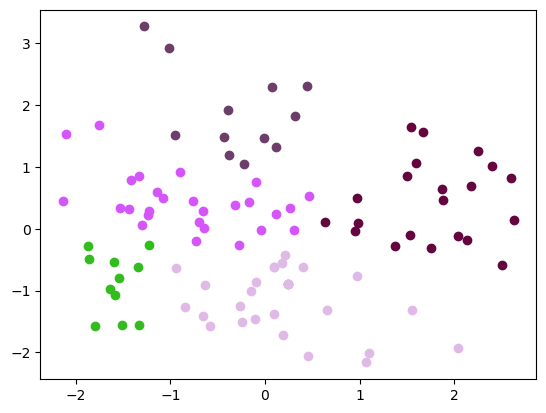

In [64]:
# do some goofy pca stuff
summed_data = np.array(list(data_cd3r.apply(lambda x: np.sum(x,0)).values))[:100]
pca = PCA(n_components=2)
pca.fit(summed_data)
summed_data = pca.transform(summed_data)

# clustering
cluster = AgglomerativeClustering( n_clusters=5,affinity='euclidean', linkage='ward')
n_clusters = cluster.n_clusters
labels = cluster.fit_predict(summed_data)

fig = plt.figure()

# Plot and color the data based off of its cluster number

if pca.n_components_ == 3:
  ax = plt.axes(projection='3d')
  for n in range(n_clusters):
    ax.scatter3D(summed_data[labels == n, 0], summed_data[labels == n, 1], summed_data[labels == n, 2], color=np.random.uniform(0, 1, 3), marker='o')
elif pca.n_components_ == 2:
  ax = plt.axes()
  for n in range(n_clusters):
    ax.scatter(summed_data[labels == n, 0], summed_data[labels == n, 1], color=np.random.uniform(0, 1, 3), marker='o')
plt.show()

(array([   7.,   17.,  150., 1946., 2924., 2765., 3811.,  694.,  254.,
         167.]),
 array([ 7. ,  8.3,  9.6, 10.9, 12.2, 13.5, 14.8, 16.1, 17.4, 18.7, 20. ]),
 <BarContainer object of 10 artists>)

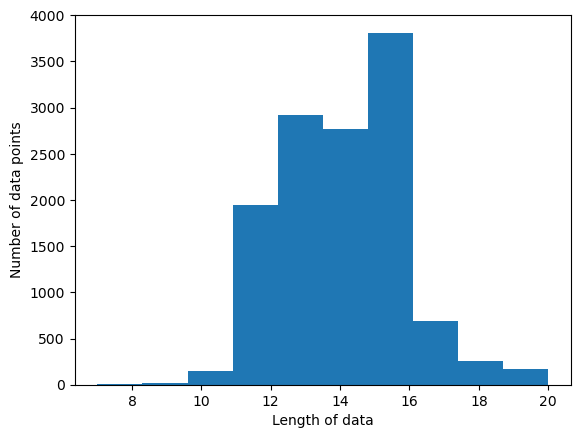

In [65]:
# Some data visualization

lengths_of_data = [len(z) for z in data_cd3r]
plt.xlabel("Length of data")
plt.ylabel("Number of data points")
plt.hist(lengths_of_data)

## BERT

In [30]:
## Create the "sentences"

# Make each entry in positives be a char array
for column in positives.columns:
  positives[column] = positives[column].apply(lambda x: list(x))
print(positives)

# sentences = "[CLS] " + "[SEP] ".join(list(positives["cdr3"])) + " [SEP] " + "[SEP]".join(list(positives["antigen.epitope"])) + " [SEP]"

# pad sentences
lengths_of_data = [len(z.split(" ")) for z in sentences]

# sentences = sentences.apply(lambda x: x + " [PAD]" * (128 - len(x.split(" "))))

train_data, test_data = train_test_split(sentences, test_size=0.2, random_state=42)
train_data

                                                   cdr3  \
0         [C, A, S, S, S, G, Q, L, T, N, T, E, A, F, F]   
1               [C, A, S, S, A, S, A, R, P, E, Q, F, F]   
2         [C, A, S, S, S, G, L, L, T, A, D, E, Q, F, F]   
3      [C, A, S, S, S, G, Q, V, S, N, T, G, E, L, F, F]   
4               [C, S, A, R, D, R, T, G, N, G, Y, T, F]   
...                                                 ...   
12730     [C, A, S, S, T, P, G, Q, G, A, Y, E, Q, Y, F]   
12731              [C, A, A, F, Q, G, A, Q, K, L, V, F]   
12732  [C, A, S, S, K, P, G, L, G, G, T, G, E, L, F, F]   
12733  [C, A, S, Q, L, G, Q, G, V, H, G, Y, G, Y, T, F]   
12734  [C, A, S, S, R, P, G, L, A, G, R, N, E, Q, F, F]   

                   antigen.epitope  
0      [G, L, C, T, L, V, A, M, L]  
1      [G, L, C, T, L, V, A, M, L]  
2      [G, L, C, T, L, V, A, M, L]  
3      [G, L, C, T, L, V, A, M, L]  
4      [G, L, C, T, L, V, A, M, L]  
...                            ...  
12730  [L, L, F, G, Y, P, V, Y, 

TypeError: sequence item 0: expected str instance, list found

In [73]:
from transformers import BertTokenizer

# create the tokenizer
tokenizer = BertTokenizer(vocab_file="./amino_acid_vocab.txt")
# encode some text
encoded_text = tokenizer.encode(" ".join(list("CSARGDGQGDLLQETQYF")))
print(encoded_text)

[2, 5, 7, 6, 17, 8, 19, 8, 9, 8, 19, 10, 10, 9, 13, 11, 9, 20, 14, 3]


In [115]:
import tensorflow as tf
import keras

## Load the bert model from checkpoint

from transformers import TFBertModel, BertConfig, BertTokenizer

# load the config file
config = BertConfig.from_pretrained('./bert_config.json')
bert = TFBertModel.from_config(config)

# create the tokenizer
tokenizer = BertTokenizer(vocab_file="./amino_acid_vocab.txt")

# encode some text
encoded_text = tokenizer.encode(positives["cdr3"][0])

# build the bert model
input_ids = tf.constant(encoded_text)[None, :]  # batch size 1
outputs = bert(input_ids)

outputs

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 3, 32), dtype=float32, numpy=
array([[[-0.29294518, -0.07976609,  0.37305385,  0.21673366,
          1.9888743 ,  0.5629502 ,  0.96953255, -0.65184706,
          0.9651298 , -0.17105128, -1.8499123 , -0.8824992 ,
          0.01257728,  1.4969128 ,  1.013123  , -0.8903647 ,
          0.0141405 , -0.07721758,  2.1592147 , -0.41971332,
          1.4462768 , -0.16494615,  0.6333498 , -0.5317216 ,
         -2.2575853 , -0.05541961, -1.1262978 , -0.94599676,
         -0.7455412 , -1.0090519 ,  0.5579892 , -0.25798178],
        [ 0.06409729, -0.71067584,  0.63345826,  0.63712794,
         -0.19362187, -0.90940785,  0.41300893, -1.6007481 ,
          0.6588908 , -0.6082856 , -0.91200495,  0.7272252 ,
         -1.1896099 ,  0.79642576,  1.316868  , -1.5340737 ,
         -0.4169009 ,  1.051012  ,  1.560839  , -1.2855355 ,
          2.4043355 , -0.01258762, -0.5316484 , -0.05272369,
         -0.7954241 ,  0.529

In [96]:
epitope_label_encoder = LabelEncoder()

x = positives["cdr3"]
y = positives["antigen.epitope"]

epitope_label_encoder.fit(y)

y = epitope_label_encoder.transform(y)

number_of_unique_epiopes = len(epitope_label_encoder.classes_)

tf.one_hot(y[0], number_of_unique_epiopes)

# Create a data set where the input is the cdr3 amino acid sequence and the output is what epitope it binds to

dataset = {}

for (x_i, y_i) in zip(x, y):
  if x_i in dataset:
    dataset[x_i] += tf.one_hot(y_i, number_of_unique_epiopes)
  else:
    dataset[x_i] = tf.one_hot(y_i, number_of_unique_epiopes)

In [123]:
temp = []
for key, val in dataset.items():
  temp.append([tokenizer(" ".join(list(key))), val])

In [126]:
bert(temp[0][0])

IndexError: Exception encountered when calling layer "bert" "                 f"(type TFBertMainLayer).

list index out of range

Call arguments received by layer "bert" "                 f"(type TFBertMainLayer):
  • input_ids=['tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)']
  • attention_mask=['tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)']
  • token_type_ids=['tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)']
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=True
  • output_attentions=False
  • output_hidden_states=False
  • return_dict=True
  • training=False